<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics

# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# spicy
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson

import warnings
warnings.filterwarnings('ignore')

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.6


In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

numpy      : 1.21.1
matplotlib : 3.4.2
statsmodels: 0.12.2
pandas     : 1.3.0
seaborn    : 0.11.1
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
sklearn    : 0.24.2



In [18]:
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
hourly_rentals.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain_type,count
0,2021-03-01,2,0.0,-1.2,98,4,1,3,2021,False,0,Monday,True,Winter,False,Night,no rain,1
1,2021-03-01,7,0.0,2.1,100,4,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,3
2,2021-03-01,8,0.0,5.1,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,1
3,2021-03-01,9,0.0,5.7,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4
4,2021-03-01,10,0.0,6.7,94,6,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4


# Linear Regression Assumptions

- Linearity
- Normality of the Error
- No Multicollinearity among Predictors
- No Autocorrelation of the Error Terms
- Homoscedasticity

## Testing Linear Regression Assumptions

In [19]:
# hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 
# df = hourlyDataWithoutOutliers.copy()
df = hourly_rentals.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category',
                'hour': 'category',
                'season': 'category',
                'peak': 'category',
                'timesofday': 'category'})
predictors = ['temp','wdsp','rhum','rain_type','holiday','season','dayofweek','working_day','peak','timesofday']

# OrdinalEnconder was chosen due 
enc = OrdinalEncoder(dtype=np.int64, categories=[['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain']])
df['rain_type'] = enc.fit_transform(df[['rain_type']])

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')

# X['rain_type'] = pd.to_numeric(X['rain_type'])

num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

dummies = pd.get_dummies(X[cat_vars], drop_first=True)
X = pd.concat([X[num_vars], dummies],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4876, 19), (2090, 19))

In [20]:
X_train.head()

,temp,rhum,wdsp,rain_type,holiday_True,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,working_day_True,season_Spring,season_Summer,season_Winter,peak_True,timesofday_Evening,timesofday_Morning,timesofday_Night
5768,7.4,91,11,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
2995,14.3,95,11,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3820,16.5,76,6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2115,17.3,91,4,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
47,4.4,89,7,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0


In [21]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)
results = model.fit()
results.params

const                  11.892247
temp                    0.123045
rhum                   -0.066474
wdsp                   -0.058638
rain_type              -0.307283
holiday_True           -0.892005
dayofweek_Monday       -0.495983
dayofweek_Saturday     -1.309451
dayofweek_Sunday       -1.687428
dayofweek_Thursday     -0.039163
dayofweek_Tuesday      -0.268075
dayofweek_Wednesday    -0.285533
working_day_True       -1.448056
season_Spring           0.035547
season_Summer          -0.357356
season_Winter          -0.007263
peak_True               0.184876
timesofday_Evening     -1.294277
timesofday_Morning     -0.427357
timesofday_Night       -2.593388
dtype: float64

In [22]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     96.96
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          6.33e-321
Time:                        20:23:50   Log-Likelihood:                -12144.
No. Observations:                4876   AIC:                         2.433e+04
Df Residuals:                    4856   BIC:                         2.446e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.8922    

In [23]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [24]:
def print_evalmetrics(actual, predicted):
    print('RMSE:', metrics.mean_squared_error(actual, predicted, squared=False))
    print('MAE:', metrics.mean_absolute_error(actual, predicted))

In [25]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    print('If non-linearity is apparent, consider adding a polynomial term')

R^2: 0.2750297238885133
Adj R^2: 0.27219314331888433
RMSE: 2.9579150231098885
MAE: 2.242131249450736
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


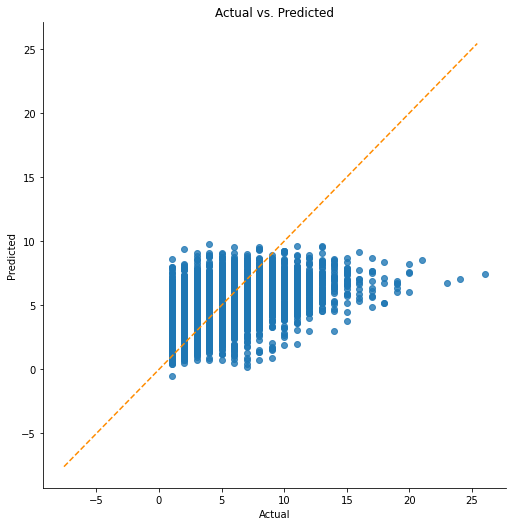

If non-linearity is apparent, consider adding a polynomial term


In [26]:
# Fitting the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_r2 = linear_model.score(X_train, y_train)
print('R^2: {0}'.format(linear_model_r2))
print('Adj R^2: {0}'.format(adjusted_r2_score(X_train, linear_model_r2)))
print_evalmetrics(y_test, linear_model.predict(X_test))
linear_assumption(linear_model, X_train, y_train)

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


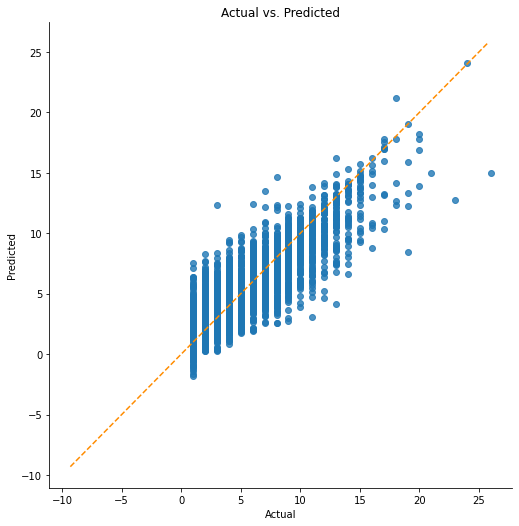

If non-linearity is apparent, consider adding a polynomial term


In [27]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 5)
X_poly = poly.fit_transform(X_train) 
# poly.fit(X_poly, y_train)
lin2 = LinearRegression()
lin2.fit(X_poly, y_train)
linear_assumption(lin2, X_poly, y_train)

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


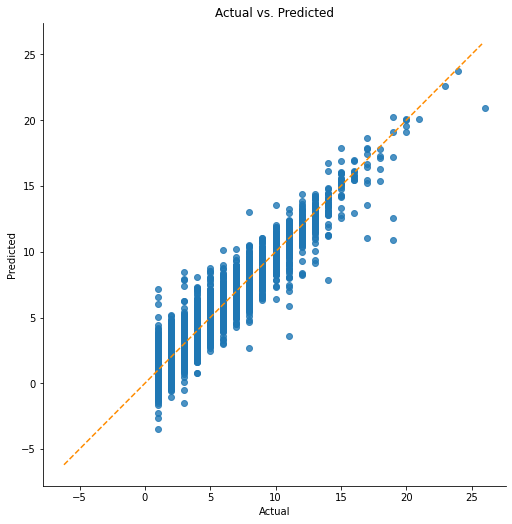

If non-linearity is apparent, consider adding a polynomial term


In [28]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 6)
X_poly = poly.fit_transform(X_train) 
# poly.fit(X_poly, y_train)
lin2 = LinearRegression()
lin2.fit(X_poly, y_train)
linear_assumption(lin2, X_poly, y_train)

In [29]:
linear_model_r2 = lin2.score(X_poly, y_train)
print('R^2: {0}'.format(linear_model_r2))
print('Adj R^2: {0}'.format(adjusted_r2_score(X_poly, linear_model_r2)))
print_evalmetrics(y_test, linear_model.predict(X_test))

R^2: 0.9097139209469696
Adj R^2: 1.0025556373080768
RMSE: 2.9579150231098885
MAE: 2.242131249450736


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


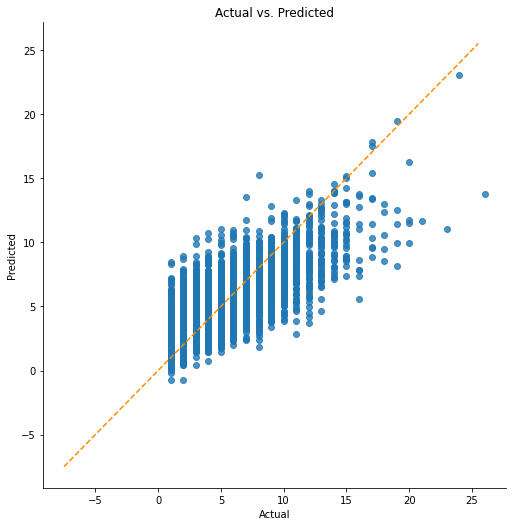

If non-linearity is apparent, consider adding a polynomial term


In [38]:
from sklearn import linear_model
model_lasso = linear_model.Lasso(alpha=0.001)
model_lasso.fit(X_poly, y_train)
linear_assumption(model_lasso, X_poly, y_train)

In [40]:
lasso_model_r2 = model_lasso.score(X_poly, y_train)
print('R^2: {0}'.format(lasso_model_r2))
print('Adj R^2: {0}'.format(adjusted_r2_score(X_poly, lasso_model_r2)))
print_evalmetrics(y_test, model_lasso.predict(poly.fit_transform(X_test)))

R^2: 0.6427110765099001
Adj R^2: 1.0101134185049454
RMSE: 5.212362052168389
MAE: 3.093858241711796


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


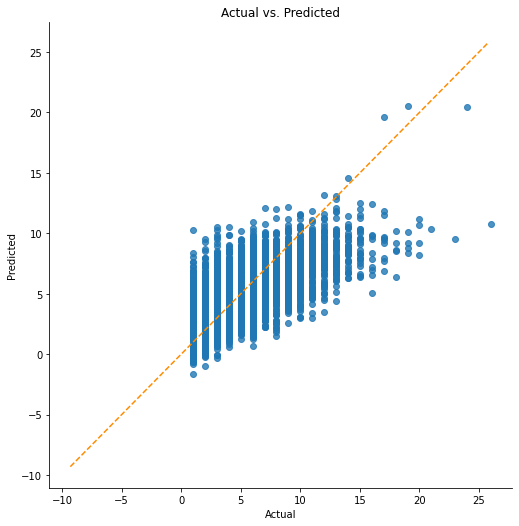

If non-linearity is apparent, consider adding a polynomial term
R^2: 0.48638399348041517
Adj R^2: 1.0145384121456407
RMSE: 3.5772487001622153
MAE: 2.486433689425824


In [41]:
model_ridge = linear_model.Ridge(0.01)
model_ridge.fit(X_poly, y_train)
linear_assumption(model_ridge, X_poly, y_train)
model_ridge_r2 = model_ridge.score(X_poly, y_train)
print('R^2: {0}'.format(model_ridge_r2))
print('Adj R^2: {0}'.format(adjusted_r2_score(X_poly, model_ridge_r2)))
print_evalmetrics(y_test, model_ridge.predict(poly.fit_transform(X_test)))

In [ ]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

In [ ]:
from scipy import stats
stats.mean(residual)

## Correlation and Multicollinearity between Predictors

In [ ]:
hourly_rentals.groupby('season')['temp'].agg('mean')

In [ ]:
hourly_rentals['temp'].describe()

In [ ]:
hourly_data_temp = hourly_rentals.copy()
hourly_data_temp['temp_type'] =  np.where(hourly_data_temp['temp'] > 10, 'High', 'Low')
hourly_data_temp['prodTempWind'] = hourly_data_temp['temp']*hourly_data_temp['wdsp']

In [ ]:
hourly_data_temp.groupby('temp_type')['temp'].agg('mean')

In [ ]:
pp = sns.pairplot(hourly_data_temp, 
             x_vars='prodTempWind',
             dropna=True, hue='temp_type',
             y_vars='count', height=8, aspect=0.8, kind="reg")
plt.show()

In [ ]:
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson
corr = hourly_data_temp['temp'].corr(hourly_data_temp['prodTempWind'])
fig,ax = plt.subplots(figsize=(13, 5))
sns.distplot(hourly_data_temp['prodTempWind'], 
             label= 'prodTempWind Skew :{0}'.format(np.round(skew(hourly_data_temp['prodTempWind']),4)), 
             color='r', ax=ax, axlabel='prodTempWind')
ax.set(title='Distribution of prodTempWind Variable')
fig.legend()
plt.show()

In [ ]:
# hourly_data_temp['prodTempWind']
# yf_target = np.cbrt(hourly_data_temp['prodTempWind'])
yf_target, lam = yeojohnson(hourly_data_temp['prodTempWind'])
fig,ax = plt.subplots(figsize=(13, 5))
sns.distplot(yf_target, label= 'Transformed Skew:{0}'.format(np.round(skew(yf_target),4)), color='g', ax=ax, axlabel='BOX-COX TRANSFORMED')
ax.set(title='Distribution of prodTempWind after Box-Cox transformation')
fig.legend()
plt.show()

In [ ]:
hourly_data_temp['prodRainWind'] = hourly_data_temp['rain']+hourly_data_temp['wdsp']
# sqrrt_target = hourly_data['prodRainWind']**(1/2)
corr = hourly_data_temp['rain'].corr(hourly_data_temp['prodRainWind'])
fig,ax = plt.subplots(figsize=(13, 5))
sns.distplot(hourly_data_temp['prodRainWind'], 
             label= 'prodRainWind Skew :{0}'.format(np.round(skew(hourly_data_temp['prodRainWind']),4)), 
             color='r', ax=ax, axlabel='prodRainWind')
ax.set(title='Distribution of prodRainWind Variable')
fig.legend()
plt.show()

In [ ]:
bcx_target, lam = boxcox(hourly_data_temp['prodRainWind'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data_temp['prodRainWind'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_data_temp['prodRainWind']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(bcx_target, label= 'Transformed Skew:{0}'.format(np.round(skew(bcx_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
yf_target, lam = yeojohnson(hourly_data_temp['prodRainWind'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data_temp['prodRainWind'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_data_temp['prodRainWind']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(yf_target, label= 'Transformed Skew:{0}'.format(np.round(skew(yf_target),4)), color='g', ax=ax[1], axlabel='Y-J TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
corrMatt = hourly_data_temp[['temp','prodTempWind','rhum','prodRainWind','wdsp', 'dew_point','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()


### Wind Speed Beaufort scale

https://www.metoffice.gov.uk/weather/guides/coast-and-sea/beaufort-scale

In [ ]:
import math
def scale(value, factor):
    """
    Multiply value by factor, allowing for None values.
    """
    return None if value is None else value * factor

def wind_ms(kn):
    """
    Convert wind from knots to metres per second
    """
    return scale(kn, 0.514)

def wind_kn(ms):
    """
    Convert wind from metres per second to knots
    """
    return scale(ms, 3.6 / 1.852)

def wind_bft(ms):
    """
    Convert wind from metres per second to Beaufort scale
    """
    _bft_threshold = (0.3, 1.5, 3.4, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6)
    if ms is None:
        return None
    return next((bft for bft in range(len(_bft_threshold)) if ms < _bft_threshold[bft]), len(_bft_threshold))

In [ ]:
hourly_data_temp['wind_bft'] = hourly_data_temp.apply(lambda row: wind_bft(wind_ms(row.wdsp)), axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=hourly_data_temp, x='wind_bft', y='count', ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')
plt.show()

In [ ]:
hourly_data_temp['wdsp'].describe()

In [ ]:
from scipy.stats import skewtest
# skewtest(hourly_data_temp['prodTempWind'])
# skewtest(sqrrt_target)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=hourly_rentals, x='wdsp', kde=True)
plt.show()

## Log Transformation

In [ ]:
log_target = np.log1p(hourly_data['count'])
# log_target = np.log1p(hourly_data['count'].sample(frac=0.2, replace=False))
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_data['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(log_target, label= 'Transformed Skew:{0}'.format(np.round(skew(log_target),4)), color='g', ax=ax[1], axlabel='LOG TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Square Root Transformation

In [ ]:
sqrrt_target = hourly_data['count']**(1/2)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_data['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(sqrrt_target, label= 'Transformed Skew:{0}'.format(np.round(skew(sqrrt_target),4)), color='g', ax=ax[1], axlabel='SQUARE ROOT TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Reciprocal Transformation

In [ ]:
re_target = 1/hourly_data['count']
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_data['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(re_target, label= 'Transformed Skew:{0}'.format(np.round(skew(re_target),4)), color='g', ax=ax[1], axlabel='INVERSE TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Box-cox Transformation

In [ ]:
bcx_target, lam = boxcox(hourly_data['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_data['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(bcx_target, label= 'Transformed Skew:{0}'.format(np.round(skew(bcx_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Yeo-Johnson Transformation

In [ ]:
yf_target, lam = yeojohnson(hourly_data['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_data['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_data['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(yf_target, label= 'Transformed Skew:{0}'.format(np.round(skew(yf_target),4)), color='g', ax=ax[1], axlabel='Y-J TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
# Multicolinearity
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

In [ ]:
ax = sns.displot(residual, kde=True)

In [ ]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
np.mean(residual)

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

In [ ]:
fig = plt.figure(figsize=(22,6))
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
plt.show()

## Testing Linear Regression Assumptions

In [ ]:
hourly_data.head()

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
# Returning the R^2 for the model
linear_r2 = pipe_linear_regression.score(X_train, y_train)
print('R^2: {0}'.format(linear_r2))

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

## Linearity

In [ ]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
linear_assumption(pipe_linear_regression, X_train, y_train)

## Normality of the Error Terms

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.histplot(df_results['Residuals'], kde=True) 
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
normal_errors_assumption(pipe_linear_regression, X_train, y_train)

## No Multicollinearity among Predictors

In [ ]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')

    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()

    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')

    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))

    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum(vif > 10 for vif in VIF)
    definite_multicollinearity = sum(vif > 100 for vif in VIF)
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [ ]:
multicollinearity_assumption(pipe_linear_regression, X_train, y_train)

## No Autocorrelation of the Error Terms

In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [ ]:
autocorrelation_assumption(pipe_linear_regression, X_train, y_train)

## Homoscedasticity

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

In [ ]:
homoscedasticity_assumption(pipe_linear_regression, X_train, y_train)